Title - FAQ Categorization

In [1]:
!pip install fasttext

Importing necessary python libraries and NLP libraries that will be required.

In [2]:
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, Bidirectional, Dense, Flatten, GlobalMaxPooling1D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import fasttext.util

Section 1 - Data Loading.

In [3]:
file_path = '/content/drive/MyDrive/NLP_MINI/nlp_faq_dataset_cleaned.csv'
df = pd.read_csv(file_path)
print(df.head())

                                         Questions           Labels
0               How do I contact customer support?  General Inquiry
1                    What are your business hours?  General Inquiry
2           Do you have a physical store location?  General Inquiry
3                     Where is your company based?  General Inquiry
4  How can I provide feedback about your services?  General Inquiry


Perform Exploratory Data Extraction (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Questions  1024 non-null   object
 1   Labels     1024 non-null   object
dtypes: object(2)
memory usage: 16.1+ KB
None
                                         Questions           Labels
count                                         1024             1024
unique                                        1013                8
top     How do I enable two-factor authentication?  General Inquiry
freq                                             2              128
Labels
General Inquiry         128
Account Management      128
Payment Issues          128
Troubleshooting         128
Subscription Queries    128
Technical Support       128
Security & Privacy      128
Product Information     128
Name: count, dtype: int64


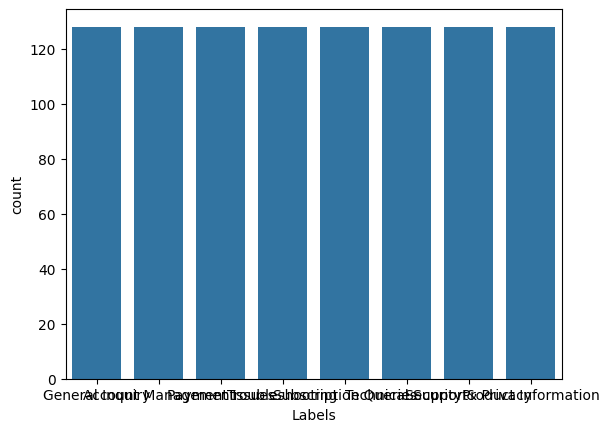

In [4]:
print(df.info())
print(df.describe())
print(df['Labels'].value_counts())
sns.countplot(x=df['Labels'])
plt.show()

In [5]:
print(df.duplicated(subset=['Questions']).sum())
df = df.drop_duplicates(subset=['Questions']).reset_index(drop=True)

11


Train - Test Split

In [6]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
test_size = len(df) - train_size - val_size

X_train, y_train = df.iloc[:train_size]['Questions'], df.iloc[:train_size]['Labels']
X_val, y_val = df.iloc[train_size:train_size + val_size]['Questions'], df.iloc[train_size:train_size + val_size]['Labels']
X_test, y_test = df.iloc[train_size + val_size:]['Questions'], df.iloc[train_size + val_size:]['Labels']

print(set(X_train) & set(X_test))
print(set(X_train) & set(X_val))
print(set(X_val) & set(X_test))


set()
set()
set()


Section 2 - Text Processing

In [7]:
from sklearn.preprocessing import LabelEncoder
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

X_train = X_train.apply(clean_text)
X_val = X_val.apply(clean_text)
X_test = X_test.apply(clean_text)

# Tokenization
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)

y_train_enc = tf.keras.utils.to_categorical(y_train_enc, num_classes=num_classes)
y_val_enc = tf.keras.utils.to_categorical(y_val_enc, num_classes=num_classes)
y_test_enc = tf.keras.utils.to_categorical(y_test_enc, num_classes=num_classes)

y_train_enc = np.array(y_train_enc).reshape(-1, num_classes)
y_val_enc = np.array(y_val_enc).reshape(-1, num_classes)
y_test_enc = np.array(y_test_enc).reshape(-1, num_classes)

print(y_train_enc.shape, y_val_enc.shape, y_test_enc.shape)

(810, 8) (101, 8) (102, 8)


Section 3 - Text Embedding

In [8]:
bow_vectorizer = CountVectorizer(max_features=max_words)
X_train_bow = bow_vectorizer.fit_transform(X_train).toarray()
X_val_bow = bow_vectorizer.transform(X_val).toarray()
X_test_bow = bow_vectorizer.transform(X_test).toarray()

tfidf_vectorizer = TfidfVectorizer(max_features=max_words)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_val_tfidf = tfidf_vectorizer.transform(X_val).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')
X_train_fasttext = np.array([np.mean([ft[word] for word in sentence.split() if word in ft], axis=0) for sentence in X_train])
X_val_fasttext = np.array([np.mean([ft[word] for word in sentence.split() if word in ft], axis=0) for sentence in X_val])
X_test_fasttext = np.array([np.mean([ft[word] for word in sentence.split() if word in ft], axis=0) for sentence in X_test])

Section 4 - Model Training

In [9]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

def build_cnn(input_dim):
    model = Sequential([
        Embedding(input_dim, 128),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm(input_dim):
    model = Sequential([
        Embedding(input_dim, 128),
        LSTM(128, return_sequences=False),
        Dense(64, activation='relu',  kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_bilstm(input_dim):
    model = Sequential([
        Embedding(input_dim, 128),
        Bidirectional(LSTM(128, return_sequences=False)),
        Dense(64, activation='relu',  kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

models = {
    'CNN': build_cnn(max_words),
    'LSTM': build_lstm(max_words),
    'BiLSTM': build_bilstm(max_words)
}

results = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_seq, y_train_enc, epochs=15, validation_data=(X_val_seq, y_val_enc), batch_size=64, callbacks=[early_stopping])
    y_pred = np.argmax(model.predict(X_test_seq), axis=1)
    y_true = np.argmax(y_test_enc, axis=1)
    results[name] = {
        'accuracy': accuracy_score(y_true, y_pred),
        'classification_report': classification_report(y_true, y_pred, output_dict=True),
        'time_taken': time.time() - start_time
    }

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.1560 - loss: 2.1528 - val_accuracy: 0.3663 - val_loss: 2.0833
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.4114 - loss: 2.0360 - val_accuracy: 0.5149 - val_loss: 1.9322
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.5022 - loss: 1.8557 - val_accuracy: 0.6634 - val_loss: 1.6525
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.5770 - loss: 1.5356 - val_accuracy: 0.6436 - val_loss: 1.2926
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.6264 - loss: 1.2287 - val_accuracy: 0.7030 - val_loss: 1.0700
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.7174 - loss: 0.9464 - val_accuracy: 0.7822 - val_loss: 0.9085
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.8092 - loss: 0.7220 - val_accuracy: 0.7822 - val_loss: 0.8401
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8372 - loss: 0.5874 - val_accuracy: 0.8119 

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Section 5 - Comparative Analysis

In [10]:
df_results = pd.DataFrame.from_dict({k: {'accuracy': v['accuracy'],'time_taken': v['time_taken']} for k, v in results.items()}, orient='index')
print(df_results)

        accuracy  time_taken
CNN     0.705882   19.350482
LSTM    0.676471   55.386843
BiLSTM  0.656863  104.647278


Section 6 - Saving Best Model

In [11]:
best_model = max(results, key=lambda x: results[x]['accuracy'])
models[best_model].save('/content/best_model.h5')

Section 7 - Predicting on Real-World Input

In [12]:
def predict_category(question):
    question = clean_text(question)
    question_seq = pad_sequences(tokenizer.texts_to_sequences([question]), maxlen=max_len)
    model = load_model('/content/best_model.h5')
    pred = model.predict(question_seq)
    label_idx = np.argmax(pred)
    label = label_encoder.inverse_transform([label_idx])[0]
    confidence = np.max(pred)
    return label, confidence

questions = ["Where can I update my billing details?", "What are the support hours?", "How do I delete my account?"]
for question in questions:
    label, confidence = predict_category(question)
    print(f"Question: {question}")
    print(f"Predicted Category: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


Question: Where can I update my billing details?
Predicted Category: Payment Issues
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Question: What are the support hours?
Predicted Category: Security & Privacy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Question: How do I delete my account?
Predicted Category: Account Management


Comparative Analysis

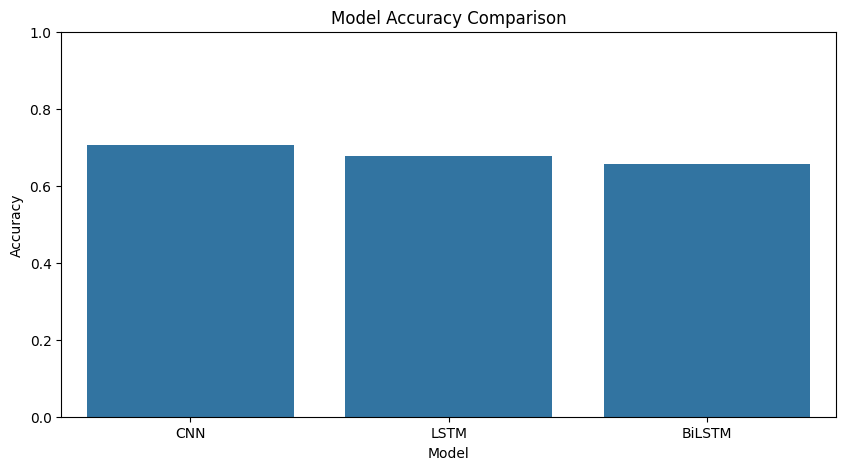

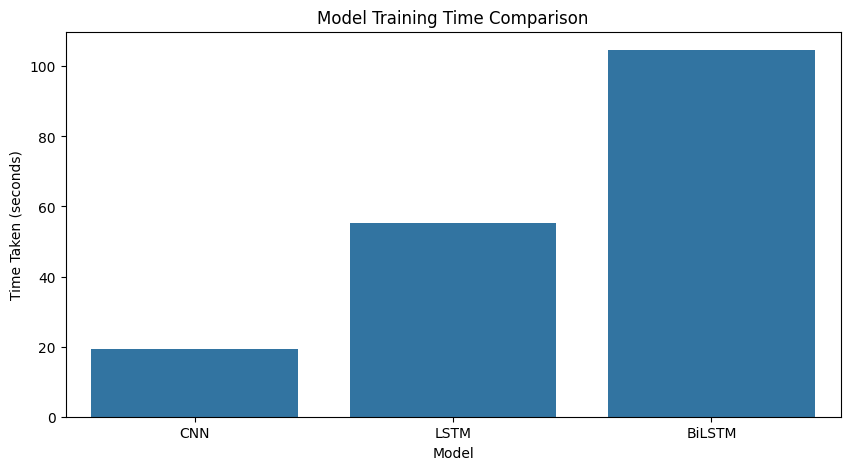

        accuracy  time_taken
CNN     0.705882   19.350482
LSTM    0.676471   55.386843
BiLSTM  0.656863  104.647278


In [13]:
df_results = pd.DataFrame.from_dict({
    k: {'accuracy': v['accuracy'], 'time_taken': v['time_taken']}
    for k, v in results.items()
}, orient='index')

plt.figure(figsize=(10, 5))
sns.barplot(x=df_results.index, y=df_results['accuracy'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=df_results.index, y=df_results['time_taken'])
plt.title('Model Training Time Comparison')
plt.ylabel('Time Taken (seconds)')
plt.xlabel('Model')
plt.show()

print(df_results)